# Combining Tide and Solar Radiation to Model Intertidal Temperatures

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

from utils import *

First, we load some hardcoded information about our Fort Ross site, where we have access to logged intertidal temperature data <citation>.

In [2]:
site = SITES['Fort Ross']

ghi_2015 = get_nsrdb_data(2015, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_2016 = get_nsrdb_data(2016, 'ghi', site['nsrdb_site_id'], site['tz'])
ghi_extended = pd.concat([ghi_2015, ghi_2016])
hot_rocks_df = get_hot_rocks_data()
year_temps_high = hot_rocks_df[hot_rocks_df['elev'] == 'high']['temp']

Found cached/site-131123-data-2015.pkl, loading...
Found cached/site-131123-data-2016.pkl, loading...


In [3]:
max_recorded_temp = year_temps_high.resample('D').max()

In [4]:
both_years_padded = [get_year_padded(2015)[0], get_year_padded(2016)[1]]
tide_series = get_noaa_tide_preds(site, both_years_padded)

<Axes: >

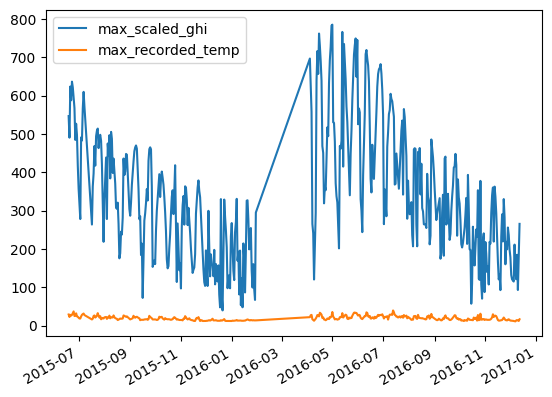

In [5]:
# Interpolate tide high/low data to get a tide value for every timestamp in the ghi data series
tide_high_res = interpolate_tide_preds(tide_series, ghi_extended.index)

# Normalize tide data to a 0-1 scale based on highest and lowest observed values over hot rocks data collection period
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

# Then "flip" the values so 1 is low tide, 0 is high tide
tide_values_inverted = 1 - tide_values_normalized

# Just making sure we didn't mess up the data shape, before we try to multiply
assert tide_values_inverted.shape == ghi_extended.shape
tide_scaled_ghi = tide_values_inverted * ghi_extended

# Resample logged temperature data and tide-scaled ghi data to daily maximum values
max_scaled_ghi = tide_scaled_ghi.resample('D').max()
max_recorded_temp = year_temps_high.resample('D').max()

# Confirm timezones are the same before we merge data into one frame
assert max_recorded_temp.index.tz == max_scaled_ghi.index.tz
df = pd.concat([max_scaled_ghi, max_recorded_temp], axis=1)
df.columns = ['max_scaled_ghi', 'max_recorded_temp']

# Drop rows where any of the values is NaN (this should only be days where there's no hot rocks data)
df = df.dropna()

# Quick sanity check plot for the data/timeframe
df.plot()

In [6]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['max_scaled_ghi'], df['max_recorded_temp'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Slope: 0.027602904496784517
Intercept: 9.786316316414487
R-squared: 0.6861106634741813
P-value: 8.291743650502877e-117
Standard error: 0.000874306199613332


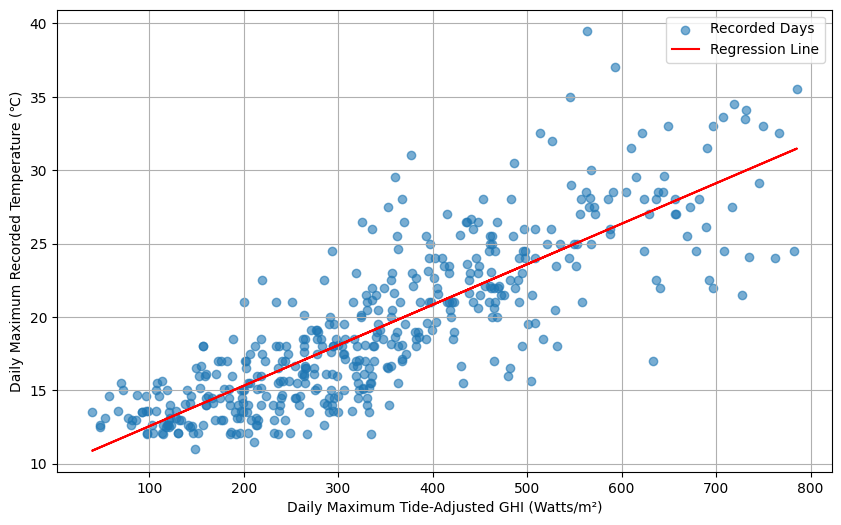

In [7]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['max_scaled_ghi'], df['max_recorded_temp'], alpha=0.6, label='Recorded Days')

# Calculate and add regression line
x = df['max_scaled_ghi']
y = intercept + slope * x
plt.plot(x, y, color='red', label='Regression Line')

# Add plot title and labels
# plt.title('Analysis of Heat Exposure in the Intertidal Zone')
plt.xlabel('Daily Maximum Tide-Adjusted GHI (Watts/m²)')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


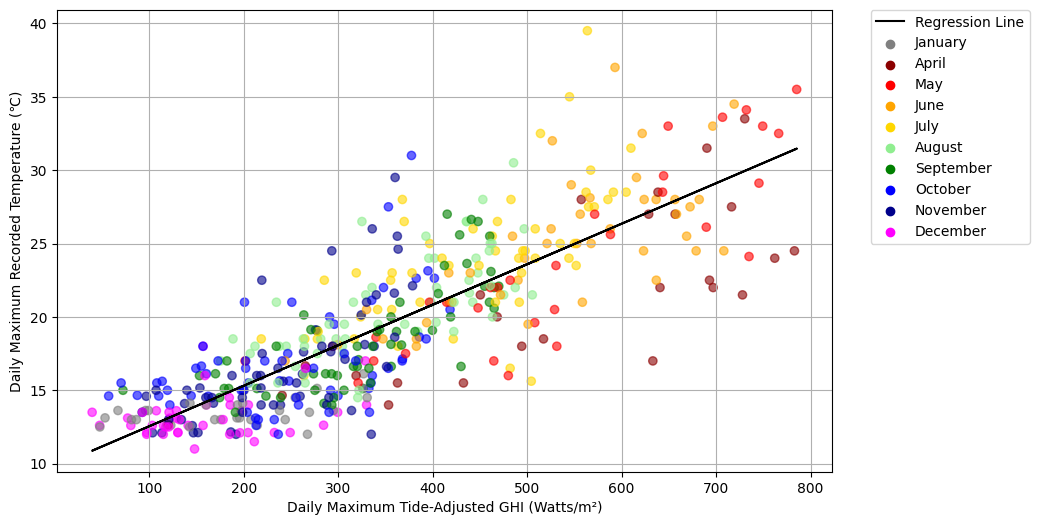

In [8]:
# Map the colors to the entries in the frame
colors = df.index.month.map(lambda x: MONTH_COLORS[x])

# Create a scatter plot with specific month colors
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['max_scaled_ghi'], df['max_recorded_temp'], color=colors, alpha=0.6)

# Add regression line
x = df['max_scaled_ghi']
y = intercept + slope * x
plt.plot(x, y, color='black', label='Regression Line')  # Use a neutral color for the line

# Add invisible points for creating the legend for months
for month, color in MONTH_COLORS.items():
    plt.scatter([], [], color=color, label=pd.to_datetime(month, format='%m').month_name())

plt.xlabel('Daily Maximum Tide-Adjusted GHI (Watts/m²)')
plt.ylabel('Daily Maximum Recorded Temperature (℃)')
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()